# Mosquito Sinks and Sources Detection

# Setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
transitions = pd.read_csv('data/kernel_regular_5000.csv', header=None)
locations = pd.read_csv('data/stp_all_sites_v3.csv')

# A Peek at the Data

In [3]:
display(transitions.shape, transitions.head())

(509, 509)

,0,1,2,3,4,5,6,7,8,9,...,499,500,501,502,503,504,505,506,507,508
0,0.7980,0.0060,0.0050,0.0035,0.0075,0.0010,0.0030,0.0030,0.0010,0.0010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0060,0.7465,0.0145,0.0120,0.0070,0.0035,0.0035,0.0055,0.0030,0.0050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0050,0.0145,0.7540,0.0160,0.0070,0.0040,0.0045,0.0070,0.0015,0.0035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0035,0.0120,0.0160,0.7705,0.0035,0.0060,0.0035,0.0025,0.0045,0.0035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0075,0.0070,0.0070,0.0035,0.7535,0.0035,0.0040,0.0015,0.0035,0.0060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
transitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Columns: 509 entries, 0 to 508
dtypes: float64(506), int64(3)
memory usage: 2.0 MB


In [5]:
display(locations.shape, locations.head())

(509, 3)

,lon,lat,pop
0,7.42917,1.61930,222
1,7.41421,1.63409,12
2,7.41390,1.63602,8
3,7.41219,1.63492,16
4,7.42591,1.64041,23


In [6]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     509 non-null    float64
 1   lat     509 non-null    float64
 2   pop     509 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 12.1 KB


# The Detector Class

In [7]:
class Detector:
    def __init__(self, transtions, locations, as_df=False, tol=1e-3, method='kmeans', *args, **kwargs):
        """
        When initializing a Detector, the community clustering
        method and sensitivity of floating point comparisons 
        may be specified here or by calling set_params().
        """
        self.tmtx   = transitions
        self.locs   = locations
        self.as_df  = as_df
        self.tol    = tol
        self.method = method
        self.args   = args
        self.kwargs = kwargs

    ####################
    # Private Methods: #
    ####################
    
    # 1. Cluster Nodes
    def communities(self):
        """
        Returns a dictionary where the key is the community id and
        the value is a list of locations grouped together using the
        kmeans algorithm. More clustering methods may be added using
        the `self.method` class attribute.
        """
        if self.method == 'kmeans':
            kmeans = KMeans(*self.args, **self.kwargs).fit(self.locs[['lon', 'lat']])
            communities = defaultdict(list)
            for loc, cid in enumerate(kmeans.labels_):
                communities[cid].append(loc)
            return communities
        else:
            raise ValueError("Method '{}' is not supported".format(method))
    
    # 2. Compute Migration Matrix
    def migrate(self, steps):
        """
        Returns the populations of each location after `steps` time
        steps.
        """
        return np.linalg.matrix_power(self.tmtx, steps) @ self.locs['pop']
    
    # 3. Calculate Ratios and Classify
    def proportions(self, communities, start_step, final_step):
        """
        Returns a dictionary such that each key is a community ID 
        and each value is a dictionary. In the second-level 
        dictionary, there are 5 keys which are explained in depth 
        below:
            1. num_in  -> number of mosquitos that migrated into 
                          this community since time step `start_step`
            2. num_out -> number of mosquitos that migrated out of 
                          this community since time step `start_step`
            3. prp_in  -> the proportion of mosquitos that entered 
                          the community since time step `start_step`
            4. prp_out -> the proportion of mosquitos that left the
                          community since time step `start_step`
            5. com     -> a list of the locations within this 
                          community
            6. type    -> either source, sink, or bridge
        """
        data = defaultdict(dict)
        for cid, community in communities.items():
            start = self.migrate(start_step)[community]
            final = self.migrate(final_step)[community]
            data[cid]['num_in']  = np.sum(final[final > start] - start[final > start])
            data[cid]['num_out'] = np.sum(start[final < start] - final[final < start])
            data[cid]['prp_in']  = data[cid]['num_in']  / (data[cid]['num_in'] + data[cid]['num_out'])
            data[cid]['prp_out'] = data[cid]['num_out'] / (data[cid]['num_in'] + data[cid]['num_out'])
            data[cid]['type']    = self.classify(data[cid]['prp_in'], data[cid]['prp_out'])
            data[cid]['com']     = community
        return data
    
    def classify(self, prop_in, prop_out):
        """
        Returns whether a community is a sink, source, or bridge.
        """
        diff = prop_in - prop_out
        if abs(diff) <= self.tol: return 'bridge'
        if diff < 0:              return 'source'
        if diff > 0:              return 'sink'
    
    # Utilities
    def pipeline(self, start, final):
        """
        Performs all steps of sink/source detection.
        """
        result = self.proportions(self.communities(), start, final)
        if self.as_df:
            return pd.DataFrame(result).transpose().sort_index()
        else:
            return result
        
    def get_cids(self, name='cid'):
        """
        Maps each location to its community ID.
        """
        coms = self.communities() 
        if self.as_df:
            self.cids = locations.copy()
            self.cids[name] = locations.index
            for cid in coms:
                self.cids.loc[coms[cid], name] = cid
            return self.cids.copy()
        else: 
            return { loc : k for k, v in coms.items() for loc in v  }
            
    ###################
    # Public Methods: #
    ###################
    
    def set_params(self, as_df=None, tol=None, method=None, *args, **kwargs):
        if  as_df is not None: self.as_df = as_df
        if    tol is not None: self.tol   = tol
        if method: self.method = method
        if   args: self.args   = args
        if kwargs: self.kwargs = kwargs
            
    def run_detection(self, final, start=0):
        self.data = self.pipeline(start, final)
        self.cids = self.get_cids()
        return self
    
    def get_loc_and_com(self):
        return self.cids.copy()
    
    def get_prp_and_com(self):
        return self.data.copy()

# Example Usage

In [8]:
d = Detector(transitions, 
             locations,
             as_df=True, 
             n_clusters=4, 
             random_state=0)

In [9]:
# If we start at time step 0, what happens at time step 1?
results = d.run_detection(1)
display(results.get_loc_and_com().head(),\
        results.get_prp_and_com().head()
)

,lon,lat,pop,cid
0,7.42917,1.61930,222,1
1,7.41421,1.63409,12,1
2,7.41390,1.63602,8,1
3,7.41219,1.63492,16,1
4,7.42591,1.64041,23,1


,num_in,num_out,prp_in,prp_out,type,com
0,30625.3,30702,0.499375,0.500625,source,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,..."
1,718.074,718.074,0.5,0.5,bridge,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,687.355,673.285,0.50517,0.49483,sink,"[89, 299, 300, 301, 304, 306, 313, 314, 315, 3..."
3,1906.48,1843.86,0.508349,0.491651,sink,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."


In [10]:
# If we start at time step 0, what happens at time step 3000?
results = d.run_detection(3000)
display(results.get_loc_and_com().head(),\
        results.get_prp_and_com().head()
)

,lon,lat,pop,cid
0,7.42917,1.61930,222,1
1,7.41421,1.63409,12,1
2,7.41390,1.63602,8,1
3,7.41219,1.63492,16,1
4,7.42591,1.64041,23,1


,num_in,num_out,prp_in,prp_out,type,com
0,58623,77529.5,0.430569,0.569431,source,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,..."
1,3219.57,3219.57,0.5,0.5,bridge,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,14450.7,1762.23,0.891307,0.108693,sink,"[89, 299, 300, 301, 304, 306, 313, 314, 315, 3..."
3,17106.1,10888.1,0.611058,0.388942,sink,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."


In [11]:
# If we start at time step 2000, what happens at time step 3000?
results = d.run_detection(3000, start=2000)
display(results.get_loc_and_com().head(),\
        results.get_prp_and_com().head()
)

,lon,lat,pop,cid
0,7.42917,1.61930,222,1
1,7.41421,1.63409,12,1
2,7.41390,1.63602,8,1
3,7.41219,1.63492,16,1
4,7.42591,1.64041,23,1


,num_in,num_out,prp_in,prp_out,type,com
0,0,8.90573,0,1,source,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,..."
1,1.10338e-05,1.10326e-05,0.500027,0.499973,bridge,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,11.1482,0.0192165,0.998279,0.00172077,sink,"[89, 299, 300, 301, 304, 306, 313, 314, 315, 3..."
3,0,2.22321,0,1,source,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6..."


In [12]:
# temp = results.get_loc_and_com().drop('cid', axis=1).to_dict()
# temp

# Plots

### First, let's see where the data is geographically:

In [13]:
import folium
import folium.plugins

In [14]:
COORDS = (7.42917, 1.61930)
folimp = folium.Map(locations=COORDS, zoom_start=13)
points = locations[['lat', 'lon']].astype('float').values
heatmp = folium.plugins.HeatMap(points.tolist(), radius=10)
folimp.add_child(heatmp)

In [15]:
cluster = folium.plugins.MarkerCluster()
for _, r in locations[['lat', 'lon']].iterrows():
    cluster.add_child(folium.Marker([float(r['lat']), float(r['lon'])]))
folimp = folium.Map(locations=COORDS, zoom_start=13)
folimp.add_child(cluster)
folimp

In [16]:
# Looks like there are two islands that are independent. Let's split 
# them up, and analyze each individually:
cids = results.get_loc_and_com()
prps = results.get_prp_and_com()

principe_locs = cids[cids['lat'] > 1.25]
principe_tmtx = transitions.iloc[principe_locs.index, principe_locs.index]
principe_coms = prps[prps.index.isin(principe_locs['cid'].unique())]

sao_tome_locs = cids[cids['lat'] < 0.50]
sao_tome_tmtx = transitions.iloc[sao_tome_locs.index, sao_tome_locs.index]
sao_tome_coms = prps[prps.index.isin(sao_tome_locs['cid'].unique())]

### Next, let's see how the communities were clustered:

In [17]:
# import geopandas as gpd
# from shapely.geometry import Point, Polygon

In [18]:
# def plot_colored_scatter(coordinate_df, color_col='cid', title='Colored Scatter Plot', xlims=None, ylims=None):
#     """
#     Returns a geographic scatter plot. The required parameter, 
#     `coordinate_df`, must consist of the following columns:
#         1. lon
#         2. lat
#         3. cid
#     """
#     # Set up the plots
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.set_title(title, fontsize=15,fontweight='bold')
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')

#     # Plot geo map. SHP file: https://data.humdata.org/dataset/sao-tome-and-principe-administrative-boundaries
#     geo_map = gpd.read_file('geo/STP_admbndp1_1m_gadm.shp')
#     geo_map.to_crs(epsg=4326)
#     geo_map.plot(ax=ax, alpha=0.4, color='black')

#     # Plot data points over map
#     geometry = [Point(xy) for xy in zip(coordinate_df['lon'], coordinate_df['lat'])]
#     geo_df = gpd.GeoDataFrame(coordinate_df.copy(), geometry=geometry)
#     geo_df.plot(column=color_col, ax=ax, alpha=0.5, legend=True, markersize=10)

#     # Show visualization
#     if xlims is not None: plt.xlim(*xlims)
#     if ylims is not None: plt.ylim(*ylims)
#     plt.show()

# plot_colored_scatter(cids, title='Sao Tome and Principe Communities')
# plot_colored_scatter(principe_locs, title='Provincia de Principe', xlims=(7.2, 7.6), ylims=(1.5, 1.72))
# plot_colored_scatter(sao_tome_locs, title='Provincia de Sao Tome', xlims=(6.4, 6.8), ylims=(-0.05, 0.5))

In [19]:
# import os
# import mpl_toolkits

# # https://stackoverflow.com/questions/52295117/basemap-import-error-in-pycharm-keyerror-proj-lib
# os.environ["PROJ_LIB"] = r"C:\Users\cdian\AppData\Local\Continuum\anaconda3\Library\share"

# from mpl_toolkits.basemap import Basemap

# # setup Lambert Conformal basemap.
# # set resolution=None to skip processing of boundary datasets.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.etopo()
# plt.show()

### Now let's use a graph to visualize the connections:

In [20]:
import geojson
from descartes import PolygonPatch

# To plot a background, convert the SHP file(s) to a geojson file
# Use: https://mygeodata.cloud/converter/shp-to-geojson
with open("STP.geojson") as json_file:
    json_data = geojson.load(json_file)

poly = json_data['features']

In [21]:
# Retrieves the polygon coordinates for the background 
principe = { 'type' : 'MultiPolygon', 'coordinates' : poly[0]['geometry']['coordinates'] }
sao_tome = { 'type' : 'MultiPolygon', 'coordinates' : poly[1]['geometry']['coordinates'] }
all_data = { 'type' : 'MultiPolygon', 'coordinates' : poly[0]['geometry']['coordinates'][:] }
all_data['coordinates'].extend(poly[1]['geometry']['coordinates'][:])

In [22]:
def plot_data(tmtx_pdf,
              locs_pdf,
              coms_pdf,
              
              nodes_cm=cmx.cool,
              nodes_fn=lambda n: n,
              min_popl=0,
              
              bordr_cm=cmx.RdGy,
              bordr_mu=2,
              bordr_op=1,
              
              edges_co=None,
              edges_cm=cmx.magma,
              edges_fn=lambda w: w,
              min_prob=0,
              edges_mu=1,
              edges_op=0.75,
              
              solid_co=None,
              solid_cm=None,
              solid_fn=None,
              solid_mu=None,
              solid_op=None,
              
              dottd_co=None,
              dottd_cm=None,
              dottd_fn=None,
              dottd_mu=None,
              dottd_op=None,
              
              bgrd_crd=None,
              bgrd_clr='#6699cc',
              bgrd_opc=0.5,
              
              bgbd_lwd=1,
              bgbd_clr='#000000',
              bgbd_opc=0.5,
              
              fig_size=(10,10),
              axis_arg='auto',
              plt_bbar=False,
              plt_pbar=False,
              plt_dbar=False,
              plt_sbar=False,
              save_fig=False
):
    """
    Inputs:
    
        Required Parameters:
            tmtx_pdf : the probability transitions as a Pandas dataframe
            locs_pdf : the locations and cids as a Pandas dataframe
            coms_pdf : the community info as a Pandas dataframe
            
        Node Settings:
            nodes_cm : the colormap for the nodes
            nodes_fn : a function to apply to the node sizes
            min_popl : if a location's population is very small use this default value
            
        Node Border Settings:
            bordr_cm : the colormap for the node borders
            bordr_mu : multiplies this value by the node sizes to come up with border sizes
            bordr_op : opacity of edges (applied to every node border)

        Edge Settings:
            edges_co : an RGB string to set the color of all edges (this will override the colormap)
            edges_cm : the colormap for the edges
            edges_fn : a function to apply to the edge weights
            min_prob : draw an edge if it is at least this value
            edges_mu : multiplies this value by the edge weights (applied after edges_fn is called)
            edges_op : opacity of edges (applied to every edge)
            
        Solid Edge Settings (if none of these are specified, the edge settings will be used):
            solid_co : an RGB string to set the color of all solid edges (this will override the colormap)
            solid_cm : the colormap for the solid edges
            solid_fn : a function to apply to the solid edge weights
            solid_mu : multiplies this value by the solid edge weights
            solid_op : sets the opacity of all the solid edges
        
        Dotted Edge Settings (if none of these are specified, the edge settings will be used):
            dottd_co : an RGB string to set the color of all dotted edges (this will override the colormap)
            dottd_cm : the colormap for the dotted edges
            dottd_fn : a function to apply to the dotted edge weights
            dottd_mu : multiplies this value by the dotted edge weights
            dottd_op : sets the opacity of all the dotted edges
        
        Background Settings:
            bgrd_crd : a dictionary compatible with descartes' PolygonPatch object (see cell above for format)
            bgrd_clr : the background color as an RGB string
            bgrd_opc : the opacity of the background
            
        Background Border Settings:
            bgbd_lwd : the line width of the background border 
            bgbd_clr : the background border color as an RGB string
            bgbd_opc : the opacity of the background border
        
        Miscellaneous Settings:        
            fig_size : tuple of figure dimensions
            axis_arg : argument for matplotlib.axes.Axes.axis
            plt_bbar : Plots the color bar for the borders. Border values are arranged such that sink < bridge < source
            plt_pbar : Plots the color bar for the population sizes
            plt_dbar : Plots the color bar for the dotted edges
            plt_sbar : Plots the color bar for the solid edges
            save_fig : If true, saves the figure as a PNG file
    
    Notes:
        Populations are scaled up to the default value then nodes_fn is called
        If an edge color is specified, it overrides the color maps
    """
    # Adjust parameters
    if solid_co is None: solid_co = edges_co
    if dottd_co is None: dottd_co = edges_co
    if solid_cm is None: solid_cm = edges_cm
    if dottd_cm is None: dottd_cm = edges_cm
    if solid_fn is None: solid_fn = edges_fn
    if dottd_fn is None: dottd_fn = edges_fn
    if solid_mu is None: solid_mu = edges_mu
    if dottd_mu is None: dottd_mu = edges_mu
    if solid_op is None: solid_op = edges_op
    if dottd_op is None: dottd_op = edges_op
    
    # Ensures node numberings are consistent with transition matrix numberings
    locs_pdf = locs_pdf.reset_index()
    
    # Ensures all population sizes are greater than or equal to min_popl then apply function
    population_sizes = locs_pdf['pop'].apply(lambda p: max(p, min_popl)).apply(nodes_fn)                  
    
    # Removes self transitions and filter out any edges below the probability threshold
    tmtx = tmtx_pdf.values
    np.fill_diagonal(tmtx, 0)
    G = nx.from_numpy_matrix(tmtx)
    G.remove_edges_from([(n1, n2) for n1, n2, w in G.edges.data('weight') if w < min_prob])
    
    # Constructs a dictionary of nodes for plotting
    nodes = { i : (r['lon'], r['lat']) for i, r in locs_pdf.iterrows() }
    
    # Separates the dotted and solid edges
    d_edges, d_wghts = [], np.array([])
    s_edges, s_wghts = [], np.array([])
    for n1, n2, w in G.edges.data('weight'):
        if locs_pdf.loc[n1, 'cid'] != locs_pdf.loc[n2, 'cid']:
            d_edges.append((n1, n2))
            d_wghts = np.append(d_wghts, dottd_fn(w) * dottd_mu)
        else:
            s_edges.append((n1, n2))
            s_wghts = np.append(s_wghts, solid_fn(w) * solid_mu)
        
    # Sets up the figure
    fig = plt.figure(figsize=fig_size)
    
    # Plots the background
    ax = fig.gca()
    if bgrd_crd is not None:
        ax.add_patch(PolygonPatch(bgrd_crd, fc=bgrd_clr, ec=bgbd_clr, alpha=bgrd_opc, zorder=0))
        ax.add_patch(PolygonPatch(bgrd_crd, fill=False, ec=bgbd_clr, alpha=bgbd_opc, linewidth=bgbd_lwd, zorder=0))
    
    # Plots dotted edges
    dotted_edges = nx.draw_networkx_edges(G, nodes,
                           edgelist=d_edges,
                           style='dashed',
                           edge_color=dottd_co if dottd_co is not None else d_wghts,
                           edge_cmap=dottd_cm,
                           alpha=dottd_op,
                           width=abs(d_wghts))
    
    # Plots solid edges
    solid_edges = nx.draw_networkx_edges(G, nodes,
                           edgelist=s_edges,
                           style='solid',
                           edge_color=solid_co if solid_co is not None else s_wghts,
                           edge_cmap=solid_cm,
                           alpha=solid_op,
                           width=abs(s_wghts))
    
    # Maps each node to its type: sink, source, bridge
    types = locs_pdf.merge(coms_pdf[['type']], left_on='cid', right_index=True)\
                    .replace({'sink' : 1, 'bridge' : 2, 'source' : 3})['type']
    
    # Plots borders
    borderdata_nodes = nx.draw_networkx_nodes(G, nodes,
                                     node_color=types,
                                     cmap=bordr_cm,
                                     alpha=bordr_op,
                                     node_size=abs(population_sizes*bordr_mu))
        
    # Plots nodes
    population_nodes = nx.draw_networkx_nodes(G, nodes,
                                     node_color=locs_pdf['cid'].values,
                                     cmap=nodes_cm,
                                     node_size=abs(population_sizes))
    
    # Plots a colorbar for the border
    if plt_bbar:
        brd_cbar = plt.colorbar(borderdata_nodes)
        brd_cbar.ax.set_ylabel('source / bridge / sink',labelpad=15,rotation=270)
    
    # Plots a colorbar for the population
    if plt_pbar:
        pop_cbar = plt.colorbar(population_nodes)
        pop_cbar.ax.set_ylabel('population',labelpad=15,rotation=270)
        
    # Plots a colorbar for the dotted edges
    if dottd_co is None and plt_dbar:
        s = 'edges' if dottd_cm == solid_cm else 'dotted edges'
        dot_cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=dottd_cm))
        dot_cbar.ax.set_ylabel(s,labelpad=15,rotation=270)
        
    # Plots a colorbar for the solid edges
    if solid_co is None and plt_sbar:
        s = 'edges' if dottd_cm == solid_cm else 'solid edges'
        sol_cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=solid_cm))
        sol_cbar.ax.set_ylabel(s,labelpad=15,rotation=270)
    
    # Saves the figure if desired
    if save_fig: 
        plt.savefig("figure.png")
    
    ax.axis(axis_arg)
    plt.show()

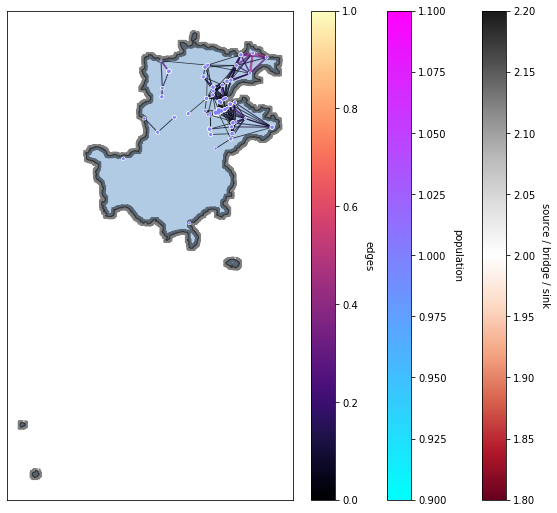

In [23]:
plot_data(principe_tmtx, principe_locs, principe_coms,\
          nodes_fn=lambda x: x**(1/3),
          bordr_mu=3,
          min_prob=0.007,
          edges_mu=100,
          bgrd_crd=principe,
          bgbd_lwd=5,
          fig_size=(10,9),
          plt_bbar=True,
          plt_pbar=True,
          plt_sbar=True
)

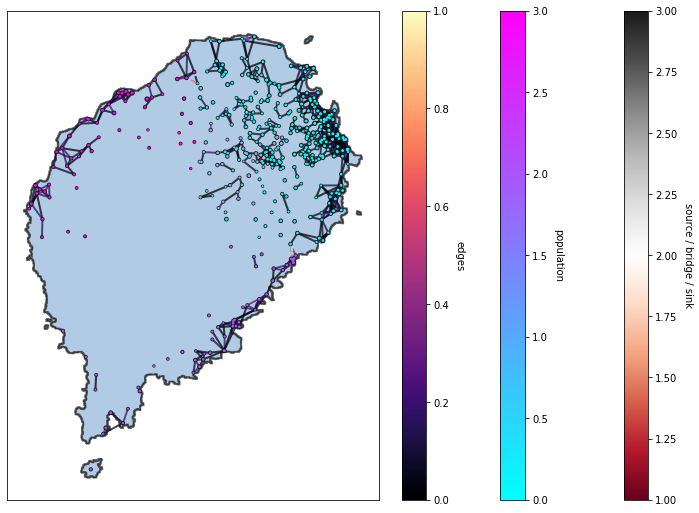

In [24]:
plot_data(sao_tome_tmtx, sao_tome_locs, sao_tome_coms,\
          nodes_fn=lambda x: x**(1/6),
          bordr_mu=5,
          edges_fn=np.log10,
          min_prob=0.009,
          edges_mu=1,
          bgrd_crd=sao_tome,
          bgbd_lwd=2,
          fig_size=(13,9),
          plt_bbar=True,
          plt_pbar=True,
          plt_sbar=True,
)

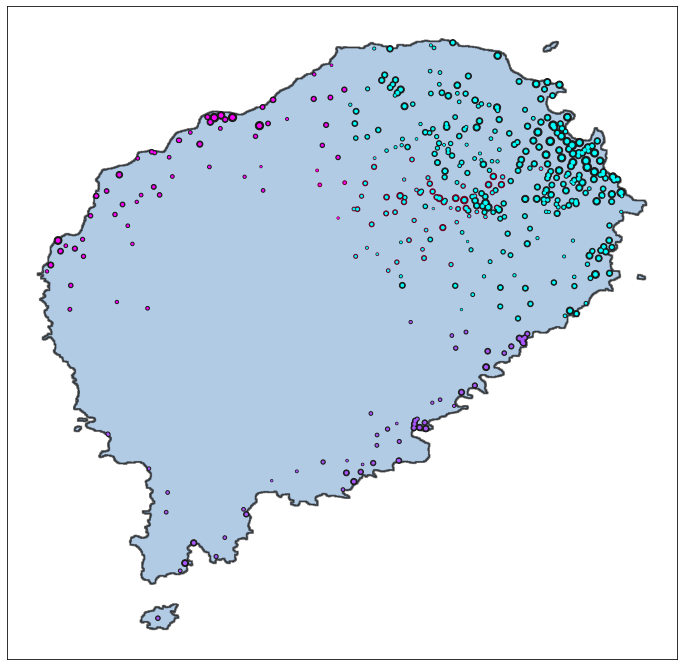

In [25]:
plot_data(sao_tome_tmtx, sao_tome_locs, sao_tome_coms,\
          nodes_fn=lambda x: x**(1/3),
          bordr_mu=5,
          edges_fn=np.log10,
          min_prob=1,
          edges_mu=1,
          bgrd_crd=sao_tome,
          bgbd_lwd=2,
          fig_size=(12,12)
)

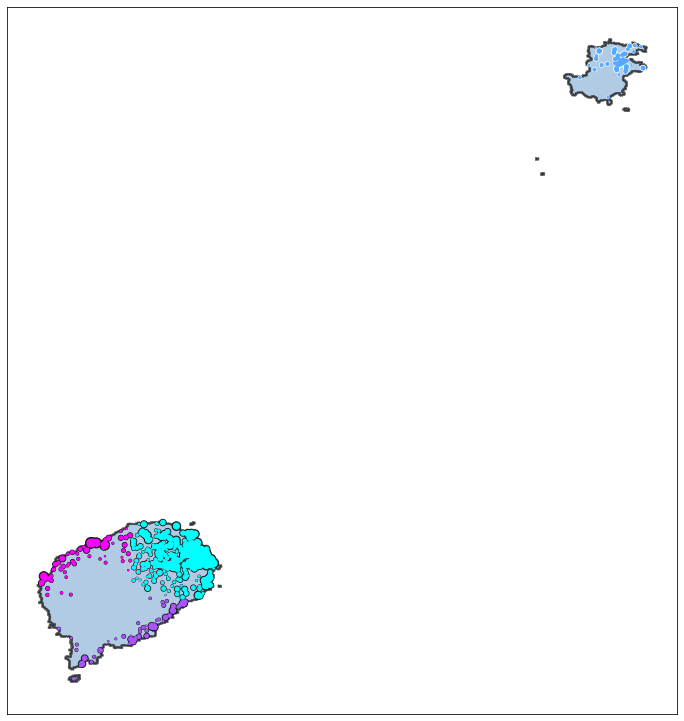

In [26]:
plot_data(transitions, results.get_loc_and_com(), results.get_prp_and_com(),\
          nodes_fn=np.sqrt,
          bordr_mu=2,
          edges_fn=np.log10,
          min_prob=1,
          edges_mu=2,
          bgrd_crd=all_data,
          bgbd_lwd=2,
          fig_size=(12,13),
 )

# References

1. Polygon Plotting: https://gis.stackexchange.com/questions/93136/how-to-plot-geo-data-using-matplotlib-python/93201#93201

2. SHP file: https://data.humdata.org/dataset/sao-tome-and-principe-administrative-boundaries

3. Colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html